<a href="https://colab.research.google.com/github/minghaozou/pytorch-tutorial-with-solutions/blob/main/solutions/06_pytorch_transfer_learning_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:**

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [1]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 33.42 MiB/s, done.
Resolving deltas: 100% (2657/2657), done.
Updating files: 100% (248/248), done.


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

In [3]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


### Prepare data

In [44]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [5]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e7baf3c8590>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [6]:
# Setup the model with pretrained weights and send it to the target device
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
#model_0 # uncomment to output (it's very long)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 75.3MB/s]


In [7]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [8]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [9]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [10]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
[INFO] Total training time: 12.675 seconds


### Make predictions on the entire test dataset with the model

In [11]:
# TODO
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Make predictions with trained model
y_preds = []
model_0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc = "Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_0(X)
    # Turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logit, dim = 1).argmax(dim = 1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/3 [00:00<?, ?it/s]

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [12]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.7 MB/s eta 0:00:00
mlxtend version: 0.23.4


In [13]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.4


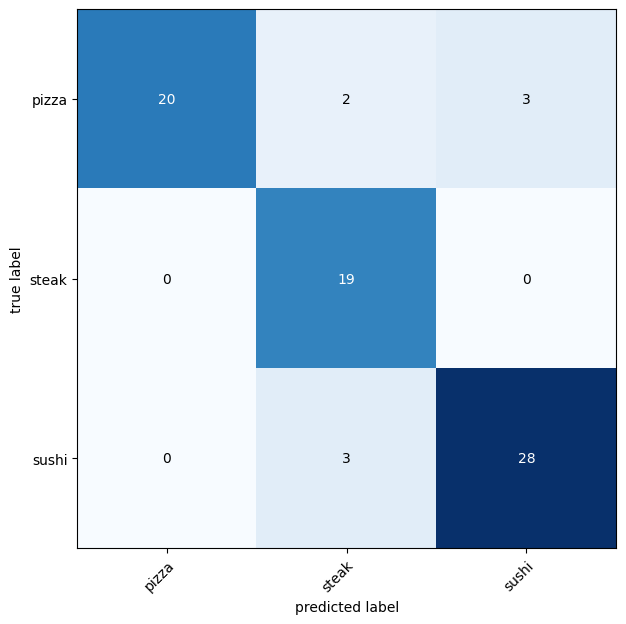

In [23]:
# TODO
from torchvision import datasets
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Use Image Folder to create datasets
test_data = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task = "multiclass")
confmat_tensor = confmat(preds = y_pred_tensor, target = torch.tensor(test_data.targets))

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

In [27]:
x = []
a = [[1, 2, 3], [3, 4, 5]]
for i in a:
  x.extend(i)
x

[1, 2, 3, 3, 4, 5]

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [29]:
# TODO
import torch
import pandas as pd
from tqdm.auto import tqdm

all_images = [] # to store image tensors (on CPU) for later plotting
all_labels = [] # ground truth (int indices)
all_preds = [] # predicted class (int indices)
all_pred_probs = [] # predicted probabilities/confidences (float)

model_0.eval()
with torch.inference_mode():
  for batch_images, batch_labels in tqdm(test_dataloader, desc = "Making predictions"):
    batch_images = batch_images.to(device)
    batch_labels = batch_labels.to(device)

    # Forward pass
    logits = model_0(batch_images)
    probs = torch.softmax(logits, dim = 1)
    confs, preds = torch.max(probs, dim = 1)

    # Move everythign to CPU and store
    all_images.extend(batch_images.cpu())
    all_labels.extend(batch_labels.cpu())
    all_preds.extend(preds.cpu())
    all_pred_probs.extend(confs.cpu())

# Convert tensor lists to plain python types
all_labels_int = [int(y) for y in all_labels]
all_preds_int = [int(p) for p in all_preds]
all_pred_probs_float = [float(p) for p in all_pred_probs]

df = pd.DataFrame({
    "idx": range(len(all_labels_int)),   # index to find images back in all_images
    "label_idx": all_labels_int,
    "pred_idx": all_preds_int,
    "pred_prob": all_pred_probs_float
})

# Store human-readable class names
df["label"] = df["label_idx"].apply(lambda i: class_names[i])
df["prediction"] = df["pred_idx"].apply(lambda i: class_names[i])

# Whether each prediction is correct
df["correct"] = df["label_idx"] == df["pred_idx"]

# Filter to only wrong predictions
wrong_df = df[~df["correct"]].copy()

# Sort: highest confidence wrong predictions first
wrong_df_sorted = wrong_df.sort_values(
    by = "pred_prob",
    ascending=False,
).reset_index(drop = True)

# Take the top 5 "most wrong"
top5_wrong = wrong_df_sorted.head(5)
top5_wrong

Making predictions:   0%|          | 0/3 [00:00<?, ?it/s]

,idx,label_idx,pred_idx,pred_prob,label,prediction,correct
0,70,2,1,0.546966,sushi,steak,False
1,44,2,1,0.449595,sushi,steak,False
2,24,0,2,0.444701,pizza,sushi,False
3,12,0,2,0.435138,pizza,sushi,False
4,15,0,2,0.426874,pizza,sushi,False


---

### 1. `df["correct"]`

This selects the **"correct" column** from the DataFrame `df`.

It’s a **boolean Series**, something like:

| row | correct |
| --- | ------- |
| 0   | True    |
| 1   | False   |
| 2   | False   |
| 3   | True    |
| …   | …       |

---

### 2. `~df["correct"]`

The `~` operator is **elementwise NOT** for booleans.

So it flips every True → False and False → True:

| row | correct | ~correct |
| --- | ------- | -------- |
| 0   | True    | False    |
| 1   | False   | True     |
| 2   | False   | True     |
| 3   | True    | False    |

In Boolean logic:

* If a prediction is **correct** → drop (False)
* If a prediction is **wrong** → keep (True)

---

### 3. `df[ ... ]` (boolean indexing)

We now use that boolean Series to **filter rows** where the condition is True.

So:

```python
df[~df["correct"]]
```

means:

> "Give me all rows where `correct == False`"

We keep only the wrong predictions.

---

### 4. `.copy()`

This creates a **separate copy of the filtered DataFrame**, instead of a *view*.

Why it matters:

* Without `.copy()`, pandas might give a `SettingWithCopyWarning`
* You could accidentally modify the original DataFrame
* `.copy()` ensures that modifications stay local to `wrong_df`

---



When we load images into PyTorch and apply:

```python
transforms.Normalize(mean=MEAN, std=STD)
```

This transform applies the operation **channel-wise**:

$$x_{\text{norm}} = \frac{x - \mu}{\sigma}$$

---

### How PyTorch `Normalize()` works

PyTorch’s `Normalize(mean, std)` applies this formula:

```python
img[channel] = (img[channel] - mean[channel]) / std[channel]
```

So if we want to invert it, we need a transform that does:

```python
img[channel] = img[channel] * std[channel] + mean[channel]
```

---

### Why the weird `inv_normalize` code works

We write:

```python
inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(IMAGENET_MEAN, IMAGENET_STD)],
    std=[1/s for s in IMAGENET_STD]
)
```

Let’s substitute it in.

---

#### Forward normalization does:

$$y = \frac{x - \mu}{\sigma}$$

#### Inverse normalization pretend-we-are-normalizing-again does:

```python
y = (x - inv_mean) / inv_std
```

But `inv_mean = -μ/σ` and `inv_std = 1/σ`.

So:

$$y = \frac{x - (-\mu/\sigma)}{1/\sigma}$$

Distribute:

$$y = x\sigma + \mu$$

---



---

## First: What happens **without** reset_index?

When you filter or sort a DataFrame, **pandas keeps the original row indexes**.

Example:

Original `df` index:

```
0
1
2
3
4
5
```

Suppose rows 1, 3, and 5 were wrong.
So `wrong_df` might look like:

| index | label | pred  | prob |
| ----- | ----- | ----- | ---- |
| 1     | pizza | steak | 0.95 |
| 3     | sushi | pizza | 0.88 |
| 5     | steak | sushi | 0.83 |

Now sort by `prob` descending — index still inherited:

| index | label | pred  | prob |
| ----- | ----- | ----- | ---- |
| 1     | pizza | steak | 0.95 |
| 3     | sushi | pizza | 0.88 |
| 5     | steak | sushi | 0.83 |

The index **stays** as 1, 3, 5

---

## Why this can be annoying

When you do:

```python
top5_wrong = wrong_df_sorted.head(5)
```

You get something that still looks like:

```
index
1
3
5
```

And then:

```python
for i, row in top5_wrong.iterrows():
    print(i)
```

You’d get:

```
1
3
5
```

**Not** 0, 1, 2 — which we usually want when looping.

---

## What does `reset_index()` do?

It creates a **new index** (0,1,2,3,...) and keeps the old index as a column.
---

## And finally — what does `drop=True` do?

It means:

> **Do NOT keep the old index as a column. Just throw it away.**

So:

```python
wrong_df_sorted.reset_index(drop=True)
```

Gives:

| index | label | pred  | prob |
| ----- | ----- | ----- | ---- |
| 0     | pizza | steak | 0.95 |
| 1     | sushi | pizza | 0.88 |
| 2     | steak | sushi | 0.83 |

Now the index is:

```
0
1
2
```

Clean. Simple. Perfect for iteration and plotting.

---

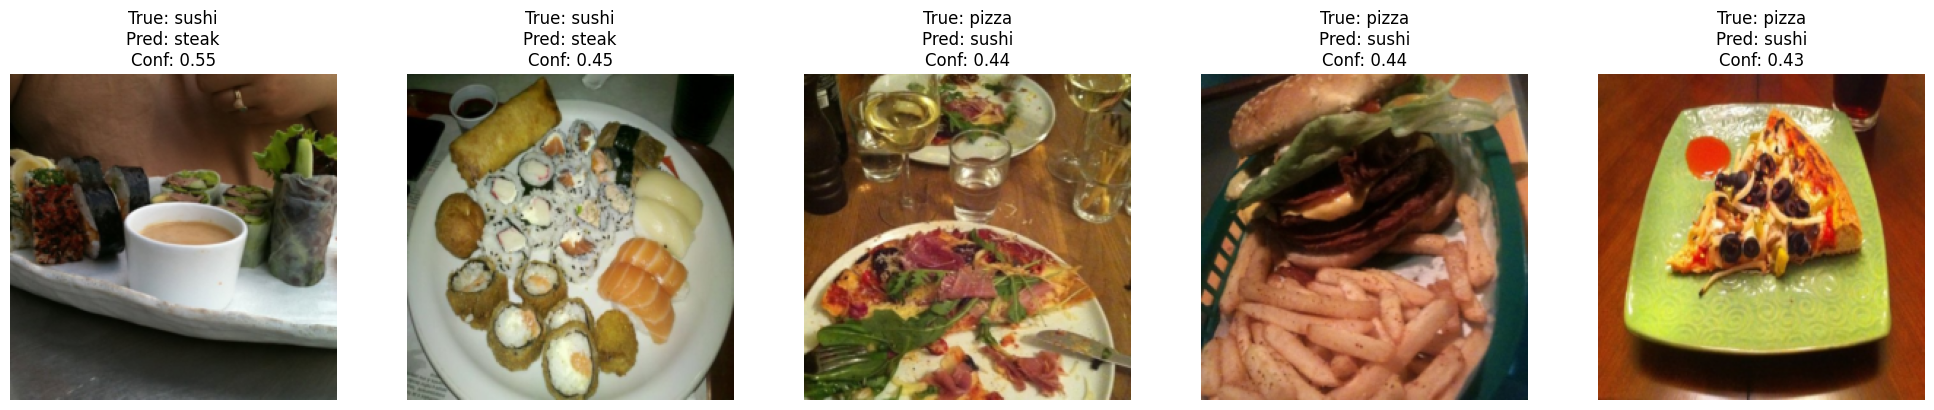

In [31]:
import matplotlib.pyplot as plt
from torchvision import transforms

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

inv_normalize = transforms.Normalize(
    mean = [-m/s for m, s in zip(IMAGENET_MEAN, IMAGENET_STD)],
    std = [1/s for s in IMAGENET_STD]
)

def denormalize_image(img_tensor):
  '''
  img_tensor: (3, H, W) normalized tensor on GPU.
  '''
  img = inv_normalize(img_tensor)
  img = torch.clamp(img, 0., 1.)
  return img

def show_image(ax, img_tensor, title = ""):
  img = denormalize_image(img_tensor)
  img = img.permute(1, 2, 0)  # CHW -> HWC
  ax.imshow(img)
  ax.axis("off")
  ax.set_title(title)

num_to_plot = len(top5_wrong)

fig, axes = plt.subplots(1, num_to_plot, figsize = (4 * num_to_plot, 4))

for ax, (_, row) in zip(axes, top5_wrong.iterrows()):
  idx = row['idx']  # index into all_images
  img_tensor = all_images[idx]  # (3, H, W) tensor on CPU

  true_label = row["label"]
  pred_label = row["prediction"]
  prob = row["pred_prob"]

  title = f"True: {true_label}\nPred: {pred_label}\nConf: {prob:.2f}"
  show_image(ax, img_tensor, title)

plt.tight_layout()
plt.show()

---

# 1. `top5_wrong.iterrows()`

`iterrows()` is a pandas method that lets you iterate **row by row** over a DataFrame.

Each iteration returns a **tuple**:

```python
(index, row)
```

Example:

```python
(3,   row data for index 3)
(10,  row data for index 10)
(22,  row data for index 22)
...
```

* The first element is the **row index** (like 3)
* The second element is a **Series** containing the row

---

# 2. `(_, row)`

This is **tuple unpacking**.

Since `iterrows()` yields:

```
(index, row)
```

We could do:

```python
for index, row in top5_wrong.iterrows():
```

But here we write `_` instead of `index` because:

**We don’t care about the index returned by iterrows.**

The underscore `_` is a **Python convention** meaning:

> “I am intentionally ignoring this value.”

So:

```python
(_, row)
```

means:

* throw away the index
* keep the `row` object (Series)

---

# 3. `zip(axes, ...)`

We want to iterate **in parallel** over:

1. `axes` → the matplotlib subplot axes
2. `top5_wrong.iterrows()` → the rows we want to plot

`zip()` pairs them element-wise:

So if we have 5 axes and 5 rows:

```
(ax0, (idx0, row0))
(ax1, (idx1, row1))
(ax2, (idx2, row2))
(ax3, (idx3, row3))
(ax4, (idx4, row4))
```

---

# 4. Putting it all together

```python
for ax, (_, row) in zip(axes, top5_wrong.iterrows()):
```

is equivalent to:

```python
for (ax, iter_tuple) in zip(axes, top5_wrong.iterrows()):
    index, row = iter_tuple   # unpack
```

But compressed into one line.

---

# 5. And then:

```python
idx = row["idx"]
```

Here, `row` is a pandas Series representing one row of the DataFrame.

If the DataFrame has columns:

```
idx, label, prediction, pred_prob
```

Then `row["idx"]` retrieves the original test-set index
so we can access:

```python
all_images[idx]
```

---


## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

In [46]:
# TODO: Get an image of pizza/steak/sushi
import requests
import torchvision
from PIL import Image

# Setup custom image path
custom_image_path_sushi = data_path / "my-sushi.jpg"

# Download the image if it doesn't already exist
if not custom_image_path_sushi.is_dir():
  with open(custom_image_path_sushi, "wb") as f:
    request = requests.get("https://github.com/minghaozou/pytorch-tutorial-with-solutions/raw/main/notebooks/sushi.jpg")
    print(f"Downloading {custom_image_path_sushi}")
    f.write(request.content)
else:
  print(f"{custom_image_path_sushi} already exists")

custom_image_sushi = Image.open(custom_image_path_sushi)

custom_image_sushi_transformed = simple_transform(custom_image_sushi)

model_0.eval()
with torch.inference_mode():
  custom_image_sushi_transformed_with_batch_size = custom_image_sushi_transformed.unsqueeze(dim = 0)

  custom_image_sushi_pred = model_0(custom_image_sushi_transformed_with_batch_size.to(device))

custom_image_sushi_pred_probs = torch.softmax(custom_image_sushi_pred, dim = 1)
print(f"Prediction probabilities: {custom_image_sushi_pred_probs}")
custom_image_sushi_pred_label = torch.argmax(custom_image_sushi_pred_probs, dim = 1)
print(f"Prediction label: {custom_image_sushi_pred_label}")
custom_image_sushi_pred_class = class_names[custom_image_sushi_pred_label]
print(f"Prediction class: {custom_image_sushi_pred_class}")

Prediction probabilities: tensor([[0.1993, 0.2977, 0.5031]], device='cuda:0')
Prediction label: tensor([2], device='cuda:0')
Prediction class: sushi


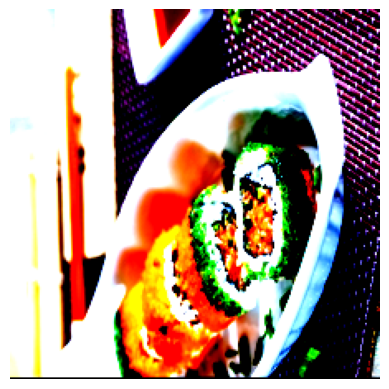

In [56]:
plt.imshow(custom_image_sushi_transformed.permute(2, 1, 0))
plt.axis(False);

In [47]:
# TODO: Get an image of not pizza/steak/sushi
# TODO: Get an image of pizza/steak/sushi
import requests
import torchvision
from PIL import Image

# Setup custom image path
custom_image_path_cat = data_path / "cat.jpg"

# Download the image if it doesn't already exist
if not custom_image_path_cat.is_dir():
  with open(custom_image_path_cat, "wb") as f:
    request = requests.get("https://github.com/minghaozou/pytorch-tutorial-with-solutions/raw/main/notebooks/cat.jpg")
    print(f"Downloading {custom_image_path_cat}")
    f.write(request.content)
else:
  print(f"{custom_image_path_cat} already exists")

custom_image_cat = Image.open(custom_image_path_cat)

custom_image_cat_transformed = simple_transform(custom_image_cat)

model_0.eval()
with torch.inference_mode():
  custom_image_cat_transformed_with_batch_size = custom_image_cat_transformed.unsqueeze(dim = 0)

  custom_image_cat_pred = model_0(custom_image_cat_transformed_with_batch_size.to(device))

custom_image_cat_pred_probs = torch.softmax(custom_image_cat_pred, dim = 1)
print(f"Prediction probabilities: {custom_image_cat_pred_probs}")
custom_image_cat_pred_label = torch.argmax(custom_image_cat_pred_probs, dim = 1)
print(f"Prediction label: {custom_image_cat_pred_label}")
custom_image_cat_pred_class = class_names[custom_image_cat_pred_label]
print(f"Prediction class: {custom_image_cat_pred_class}")

Prediction probabilities: tensor([[0.1530, 0.4200, 0.4270]], device='cuda:0')
Prediction label: tensor([2], device='cuda:0')
Prediction class: sushi


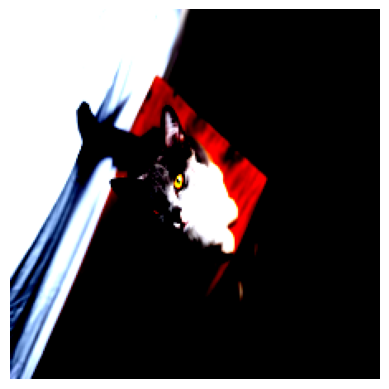

In [57]:
plt.imshow(custom_image_cat_transformed.permute(2, 1, 0))
plt.axis(False);

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [60]:
# TODO: Recreate a new model
import torchvision

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Setup the model with pretrained weights and send it to the target device
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_1 = torchvision.models.efficientnet_b0(weights=weights).to(device)

for param in model_1.features.parameters():
  param.requires_grad = False

# length of class_names
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p = 0.2, inplace = True),
    torch.nn.Linear(
        in_features = 1280,
        out_features = len(class_names),
        bias = True
    )
).to(device)

In [63]:
# TODO: Train the model for 10 epochs
from timeit import default_timer as timer
from going_modular.going_modular import engine
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(), lr = 0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
start_time = timer()

# Setup training and save the results
results = engine.train(
    model = model_1,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    optimizer = optimizer,
    loss_fn = loss_fn,
    epochs = 10,
    device = device
)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0675 | train_acc: 0.3984 | test_loss: 0.8842 | test_acc: 0.6714
Epoch: 2 | train_loss: 0.8674 | train_acc: 0.6523 | test_loss: 0.8028 | test_acc: 0.7538
Epoch: 3 | train_loss: 0.7838 | train_acc: 0.7969 | test_loss: 0.7267 | test_acc: 0.7936
Epoch: 4 | train_loss: 0.7347 | train_acc: 0.7617 | test_loss: 0.6268 | test_acc: 0.8456
Epoch: 5 | train_loss: 0.6256 | train_acc: 0.8008 | test_loss: 0.6057 | test_acc: 0.9072
Epoch: 6 | train_loss: 0.5640 | train_acc: 0.9141 | test_loss: 0.5513 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.5226 | train_acc: 0.9258 | test_loss: 0.5196 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.5400 | train_acc: 0.7969 | test_loss: 0.5237 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.5847 | train_acc: 0.8164 | test_loss: 0.4897 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.4893 | train_acc: 0.7891 | test_loss: 0.4138 | test_acc: 0.8759
[INFO] Total training time: 17.241 seconds


## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).


### Get 20% data

In [64]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [65]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [66]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e7bacefd730>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [72]:
# TODO
import torchvision

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Setup the model with pretrained weights and send it to the target device
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_2 = torchvision.models.efficientnet_b0(weights=weights).to(device)

for param in model_2.features.parameters():
  param.requires_grad = False

# length of class_names
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p = 0.2, inplace = True),
    torch.nn.Linear(
        in_features = 1280,
        out_features = len(class_names),
        bias = True
    )
).to(device)

### Train a model with 20% of the data

In [73]:
# TODO
from timeit import default_timer as timer
from going_modular.going_modular import engine
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_2.parameters(), lr = 0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
start_time = timer()

# Setup training and save the results
results = engine.train(
    model = model_2,
    train_dataloader = train_dataloader_20_percent,
    test_dataloader = test_dataloader_20_percent,
    optimizer = optimizer,
    loss_fn = loss_fn,
    epochs = 10,
    device = device
)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9646 | train_acc: 0.5771 | test_loss: 0.6750 | test_acc: 0.8670
Epoch: 2 | train_loss: 0.6871 | train_acc: 0.8396 | test_loss: 0.5394 | test_acc: 0.8915
Epoch: 3 | train_loss: 0.5794 | train_acc: 0.8438 | test_loss: 0.4557 | test_acc: 0.9313
Epoch: 4 | train_loss: 0.4525 | train_acc: 0.8812 | test_loss: 0.4084 | test_acc: 0.9250
Epoch: 5 | train_loss: 0.4446 | train_acc: 0.8958 | test_loss: 0.3843 | test_acc: 0.9131
Epoch: 6 | train_loss: 0.4224 | train_acc: 0.8313 | test_loss: 0.3563 | test_acc: 0.9159
Epoch: 7 | train_loss: 0.4186 | train_acc: 0.8479 | test_loss: 0.3166 | test_acc: 0.9375
Epoch: 8 | train_loss: 0.4008 | train_acc: 0.8562 | test_loss: 0.3235 | test_acc: 0.9006
Epoch: 9 | train_loss: 0.3222 | train_acc: 0.8792 | test_loss: 0.3086 | test_acc: 0.9256
Epoch: 10 | train_loss: 0.3389 | train_acc: 0.9042 | test_loss: 0.2711 | test_acc: 0.9284
[INFO] Total training time: 30.039 seconds


## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [83]:
# TODO
import torchvision
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
auto_transforms = weights.transforms()

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Setup the model with pretrained weights and send it to the target device
model_effnet_b2 = torchvision.models.efficientnet_b2(weights=weights).to(device)

for param in model_effnet_b2.features.parameters():
  param.requires_grad = False

auto_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [84]:
from torchinfo import summary
summary(
    model = model_effnet_b2,
    input_size=(32, 3, 288, 288),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 288, 288]    [32, 1000]           --                   Partial
├─Sequential (features)                                      [32, 3, 288, 288]    [32, 1408, 9, 9]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 288, 288]    [32, 32, 144, 144]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 288, 288]    [32, 32, 144, 144]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 144, 144]   [32, 32, 144, 144]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 144, 144]   [32, 32, 144, 144]   --                   --
│    └─Sequential (1)                                        [32, 32, 144, 144]   [32, 

In [85]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_effnet_b2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1408,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [86]:
from timeit import default_timer as timer
from going_modular.going_modular import engine
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_effnet_b2.parameters(), lr = 0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
start_time = timer()

# Setup training and save the results
results = engine.train(
    model = model_effnet_b2,
    train_dataloader = train_dataloader_20_percent,
    test_dataloader = test_dataloader_20_percent,
    optimizer = optimizer,
    loss_fn = loss_fn,
    epochs = 10,
    device = device
)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9985 | train_acc: 0.5479 | test_loss: 0.7716 | test_acc: 0.9006
Epoch: 2 | train_loss: 0.7154 | train_acc: 0.8375 | test_loss: 0.6248 | test_acc: 0.8699
Epoch: 3 | train_loss: 0.5767 | train_acc: 0.8792 | test_loss: 0.5399 | test_acc: 0.8909
Epoch: 4 | train_loss: 0.4430 | train_acc: 0.8938 | test_loss: 0.4864 | test_acc: 0.8943
Epoch: 5 | train_loss: 0.4481 | train_acc: 0.8646 | test_loss: 0.4412 | test_acc: 0.8852
Epoch: 6 | train_loss: 0.4163 | train_acc: 0.8667 | test_loss: 0.4146 | test_acc: 0.9034
Epoch: 7 | train_loss: 0.4183 | train_acc: 0.8521 | test_loss: 0.3808 | test_acc: 0.9034
Epoch: 8 | train_loss: 0.3821 | train_acc: 0.8604 | test_loss: 0.4044 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.3827 | train_acc: 0.8854 | test_loss: 0.3720 | test_acc: 0.8943
Epoch: 10 | train_loss: 0.3530 | train_acc: 0.8625 | test_loss: 0.3403 | test_acc: 0.9159
[INFO] Total training time: 31.314 seconds
